<a href="https://colab.research.google.com/github/edcalderin/Competencia_Puntaje_Recencia/blob/master/Copia_de_Competencia_Puntaje_Recencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import time
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import multiprocessing as mp

**For NLP**

In [3]:
# Install
!pip install -U spacy
!pip install googletrans==3.1.0a0
!python -m spacy download en_core_web_sm
!pip install -U textblob
!python -m textblob.download_corpora

2021-08-12 05:31:27.329097: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 13.6 MB 73 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /ro

In [4]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from googletrans import Translator
from textblob import TextBlob

## Importing data

Getting training and test datasets from Drive.

In [5]:
# Train
PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
train = pd.read_csv(PREFIX+'/Train.csv')
test = pd.read_csv(PREFIX+'/Test.csv')

## Exploring

In [6]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [7]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [8]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [9]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

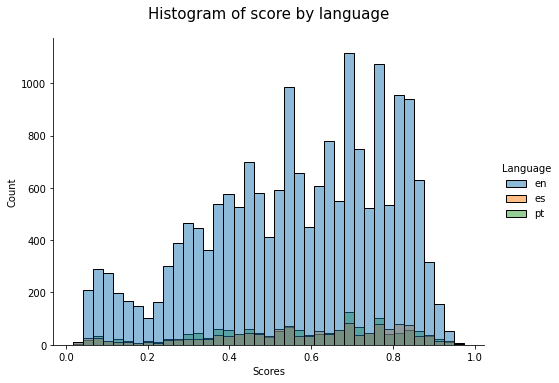

In [10]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

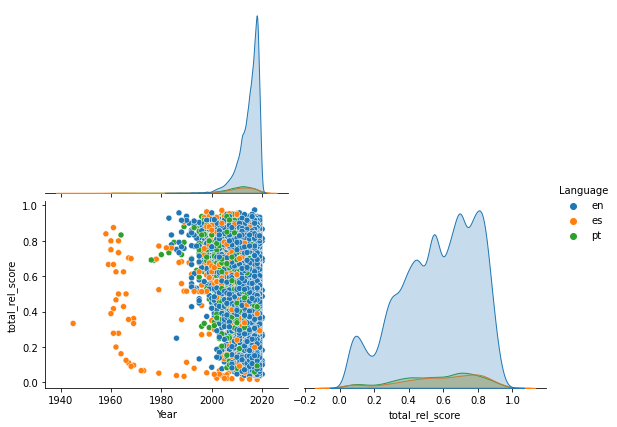

In [11]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [12]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [13]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [14]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [15]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Translating Title

Let's translate the abstract of every research paper since it contains a longer text than title

In [16]:
api = Translator()
def translate_texts(df, train=True):    
    PATH = 'abstract_translations.csv' # Saving translation to save time
    if not (train and os.path.exists(PATH)):
        translated_list = []
        for row in tqdm(df[['Abstract','Language']].values):
            if row[1]=='en': # It won't translate if abstract is already written in English 
                translated_list.append(row[0])
            else:
                translation = api.translate(row[0], src=row[1])
                translated_list.append(translation.text)
                time.sleep(1) # Important to avoid multiple request to Google Translate api.
        translations = pd.DataFrame({'text': translated_list})
        translations.to_csv(PATH, index=False) # Saving translations
    return pd.read_csv(PATH)['text']           

In [17]:
train['abstract_english'] = translate_texts(train)

### Applying NLP

#### Tokenizing

In [19]:
# Loading spacy for english language
nlp_en = spacy.load('en_core_web_sm')

In [20]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(serie_translated):
    '''
    dataframe: Pandas Dataframe with one column 'text'
    '''
    tokens_doc = []
    for text in tqdm(serie_translated):
        # Filtering 
        tokens = [word.lemma_ for word in nlp_en(text) 
                  if word.pos_ not in ['PUNCT', 'SPACE', 'NUM']
                  and not word.is_stop      
                  and len(word)>2            
                ]
        tokens_doc.append(' '.join(tokens))
    return tokens_doc

In [21]:
%%time
train['Abstract_tokens'] = get_tokens(train['abstract_english'])


CPU times: user 16min 4s, sys: 12.9 s, total: 16min 17s
Wall time: 16min 18s


In [31]:
train[['Abstract', 'Abstract_tokens']].head()

,Abstract,Abstract_tokens
0,The present study investigates an inventory mo...,present study investigate inventory model non ...
1,AIM: To investigate the clinical characteristi...,AIM investigate clinical characteristic surgic...
2,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...",Aflatoxin AFM1 ochratoxin OTA widely coexist m...
3,Background/Aim: There are still unrevealed tre...,background Aim unreveale treasure traditional ...
4,Impairment in empathy has been demonstrated in...,impairment empathy demonstrate patient schizop...


#### Getting sentiment

In [32]:
def get_sentiment_score(list_text):
    subjectivities = []
    for row in tqdm(list_text):
        text = TextBlob(row)
        subjectivity = text.sentiment.polarity
        subjectivities.append(subjectivity)
    return subjectivities

In [33]:
train['subjectivity'] = get_sentiment_score(abstract_english)

#### Vectorization

In [34]:
vectorizer_model = TfidfVectorizer(min_df=70, strip_accents='ascii', ngram_range=(1,2))
vectorizer_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [35]:
train_with_tfidf = train.join(pd.DataFrame(vectorizer_values.toarray(),
                                           columns=vectorizer_model.get_feature_names())
                    )

### Dropping unnecessary columns:

In [60]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens', 'abstract_english']
train_with_tfidf.drop(COLS, axis=1, inplace=True)

In [37]:
train_with_tfidf.head()

,Year,total_rel_score,en,es,pt,subjectivity,001,01,05,05 conclusion,10,100,11,12,13,14,15,16,17,18,1department,1st,20,21,25,2department,30,3department,40,50,60,8217,8722,95,abdominal,ability,abiotic,able,abnormal,abnormality,...,wide,wide range,widely,widespread,width,wild,wild type,wind,window,winter,wireless,wistar,wistar rat,woman,woman man,wood,word,work,worker,working,world,world health,worldwide,wound,write,writer,writing,xrd,year,year age,year old,year period,year year,yeast,yellow,yield,young,youth,zinc,zone
0,0.946667,0.630682,1,0,0,0.040476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.986667,0.583333,1,0,0,0.106250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.067636,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.036676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032546,0.000000,0.051499,0.0,0.0,0.0,0.0,0.0,0.054021,0.0,0.0,0.0
2,0.986667,0.372222,1,0,0,0.059936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.074489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.960000,0.661765,1,0,0,0.070774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.933333,0.373737,1,0,0,0.093636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166476,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.107747,0.112309,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [38]:
train_with_tfidf.shape

(21456, 4345)

## Training

In [39]:
X = train_with_tfidf.drop('total_rel_score', axis=1)
y = train_with_tfidf.total_rel_score

### Training for validation

For validation efects, I will train with 80/20 rule to achieve a lower RMSLE error

In [44]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)

In [45]:
%%time
model = BayesianRidge()
model.fit(X_train, y_train)

CPU times: user 7min 43s, sys: 9.21 s, total: 7min 52s
Wall time: 4min 1s


In [47]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.1289261368236143
RMSLE Test 0.13465371443741492


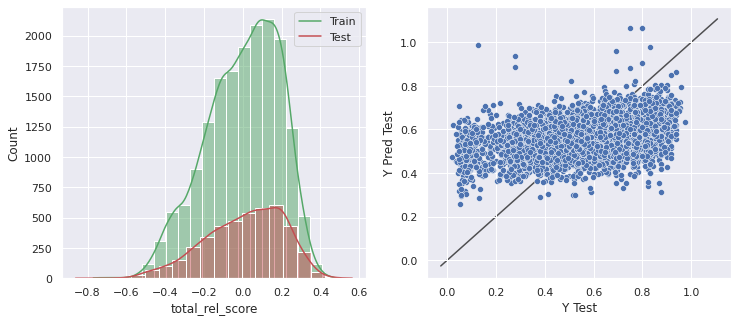

In [48]:
results_metric(model)

### Training with full data

Training with entire dataset only to predict with test dataset and creating submission

In [49]:
%%time
full_model = BayesianRidge()
full_model.fit(X, y)
print('Model has been trained!')

Model has been trained!
CPU times: user 8min 11s, sys: 13.1 s, total: 8min 25s
Wall time: 4min 20s


## Predictions

Preprocessing Test dataset

In [50]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [51]:
id = test.id

Translating:

In [53]:
test['abstract_english'] = translate_texts(test, train=False)

Applying NLP

In [66]:
# Getting sentiment score
test['subjectivity'] = get_sentiment_score(test['abstract_english'])

In [55]:
%%time
test['Abmstract_tokens'] = get_tokens(test['abstract_english'])


CPU times: user 7min 50s, sys: 6.21 s, total: 7min 56s
Wall time: 7min 56s


In [67]:
vectorizer_values_test = vectorizer_model.transform(test['Abstract_tokens'])
test_with_tfidf = test.join(pd.DataFrame(vectorizer_values_test.toarray(), 
                        columns=vectorizer_model.get_feature_names())
        )

Removing same columns as train dataset:

In [68]:
test_with_tfidf.drop(COLS, axis=1, inplace=True)

In [69]:
test_with_tfidf.head()

,Year,en,es,pt,subjectivity,001,01,05,05 conclusion,10,100,11,12,13,14,15,16,17,18,1department,1st,20,21,25,2department,30,3department,40,50,60,8217,8722,95,abdominal,ability,abiotic,able,abnormal,abnormality,abordagem,...,wide,wide range,widely,widespread,width,wild,wild type,wind,window,winter,wireless,wistar,wistar rat,woman,woman man,wood,word,work,worker,working,world,world health,worldwide,wound,write,writer,writing,xrd,year,year age,year old,year period,year year,yeast,yellow,yield,young,youth,zinc,zone
0,0.933333,1,0,0,-0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.061446,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.906667,1,0,0,0.020833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215719,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.866667,1,0,0,0.094464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.048027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.813333,0,1,0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.131812,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.973333,1,0,0,0.068561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.025404,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
y_pred = model.predict(test_with_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

,id,total_rel_score
0,1,0.634630
1,2,0.573467
2,3,0.655310
3,4,0.549312
4,5,0.597989


In [71]:
predictions.to_csv(PREFIX+'/SampleSubmission.csv', index=False)